**Team 2**

• Team Members:

• Lalit Manesh More

• Atharva Hanumant Admile

• Sarthak Nivrutti Nagave

• Venkatesh Ganesh Gudade

• Ankita Yatish Kakade

• Sinchan Santosh Rao

• Anish Kadam

Project Task:

Team 2 : **Predictive Maintenance System (Time-Series)**

Objective:

Predict equipment failure using time-series sensor data.

Requirements:

• Clean dataset

• Feature engineering

• Train regression/classification model

• Predict failure probability

• Visualize predictions

• Provide performance metrics (MSE, F1, Accuracy)

Difficulty: Advanced ML + Time-Series Analysis

In [131]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, f1_score, mean_squared_error,
    roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [132]:
# LOAD & CLEAN DATA
df = pd.read_csv("/content/sample_data/predictive_maintenance.csv")

df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values(["Machine_ID","Time"]).reset_index(drop=True)

df = df.drop_duplicates()
print("Dataset Shape:", df.shape)

Dataset Shape: (10000, 12)


In [133]:
# FEATURE ENGINEERING
sensor_cols = [
    "Temperature","Vibration","Pressure",
    "Humidity","Voltage","Rotation_Speed"
]

# Rolling statistics
for col in sensor_cols:
    df[f"{col}_roll_mean"] = df.groupby("Machine_ID")[col].rolling(5).mean().reset_index(0,drop=True)
    df[f"{col}_roll_std"]  = df.groupby("Machine_ID")[col].rolling(5).std().reset_index(0,drop=True)

# Rate of change
for col in sensor_cols:
    df[f"{col}_roc"] = df.groupby("Machine_ID")[col].pct_change()

# Lag feature
for col in sensor_cols:
    df[f"{col}_lag1"] = df.groupby("Machine_ID")[col].shift(1)

df = df.dropna().reset_index(drop=True)

In [134]:
# DEFINE TARGET (Predict Failure Soon)
y = df["Failure_Soon"]

X = df.drop([
    "Time","Machine_ID",
    "Failure","Failure_Soon",
    "RUL","Health_Index"
], axis=1)

In [135]:
# TIME-SERIES SPLIT (NO LEAKAGE)
split = int(len(X) * 0.8)

X_train = X.iloc[:split]
X_test  = X.iloc[split:]

y_train = y.iloc[:split]
y_test  = y.iloc[split:]

In [136]:
# RANDOM FOREST Model
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest Results
Accuracy: 0.9786585365853658
F1: 0.8264462809917356
MSE: 0.021341463414634148
ROC-AUC: 0.995123106060606


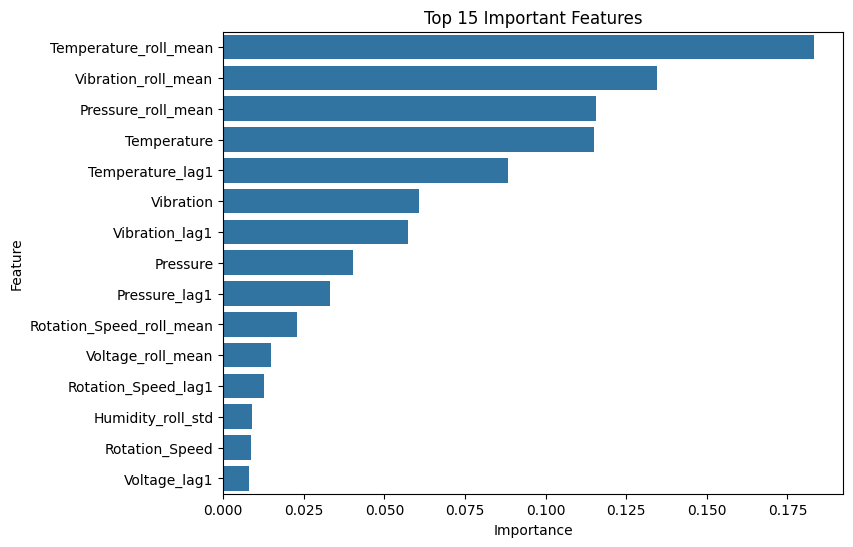

In [137]:
# RF Feature Importance
importances = rf.feature_importances_
feat_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_df.head(15))
plt.title("Top 15 Important Features")
plt.show()

In [138]:
# LSTM (Deep Time-Series Model)
# Scale AFTER split
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [139]:
# Create Sequences
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

X_seq_train, y_seq_train = create_sequences(
    pd.DataFrame(X_train_scaled), y_train.reset_index(drop=True), 30
)

X_seq_test, y_seq_test = create_sequences(
    pd.DataFrame(X_test_scaled), y_test.reset_index(drop=True), 30
)

In [140]:
# Build LSTM Model
model = Sequential()

model.add(LSTM(128, return_sequences=True,
               input_shape=(X_seq_train.shape[1], X_seq_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64))
model.add(Dropout(0.3))

model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [141]:
# Train
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_seq_train,
    y_seq_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9198 - loss: 0.1770 - val_accuracy: 0.9331 - val_loss: 0.1787
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9590 - loss: 0.0756 - val_accuracy: 0.9331 - val_loss: 0.1952
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9573 - loss: 0.0875 - val_accuracy: 0.9522 - val_loss: 0.0858
Epoch 4/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9719 - loss: 0.0586 - val_accuracy: 0.8394 - val_loss: 0.2913
Epoch 5/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9595 - loss: 0.0855 - val_accuracy: 0.9694 - val_loss: 0.0681
Epoch 6/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9780 - loss: 0.0521 - val_accuracy: 0.9764 - val_loss: 0.0772
Epoch 7/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9774 - loss: 0.0518 - val_accuracy: 0.9777 - val_loss: 0.0561
Epoch 8/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9791 - loss: 0.0466 - val_accu

In [142]:
# Predict & Optimize Threshold
y_prob_lstm = model.predict(X_seq_test).ravel()

from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_seq_test, y_prob_lstm)

f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print("Best Threshold:", best_threshold)

y_pred_lstm = (y_prob_lstm > best_threshold).astype(int)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Best Threshold: 0.56719095


In [143]:
# LSTM Evaluation
print("LSTM Results")
print("Accuracy:", accuracy_score(y_seq_test, y_pred_lstm))
print("F1:", f1_score(y_seq_test, y_pred_lstm))
print("MSE:", mean_squared_error(y_seq_test, y_pred_lstm))
print("ROC-AUC:", roc_auc_score(y_seq_test, y_prob_lstm))

LSTM Results
Accuracy: 0.9814241486068112
F1: 0.8524590163934426
MSE: 0.018575851393188854
ROC-AUC: 0.9933672533920058


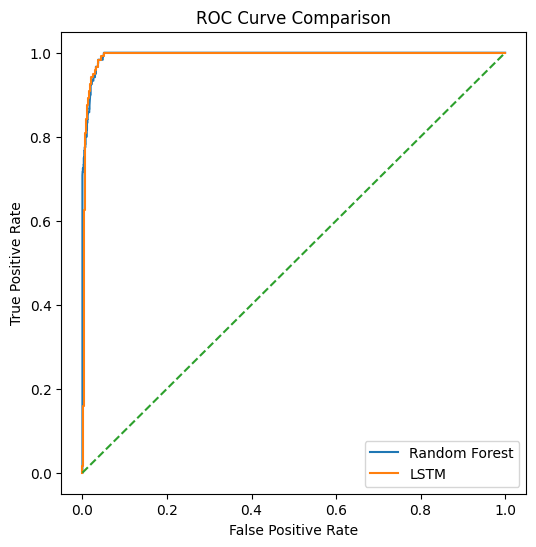

In [144]:
# ROC Curve Comparison
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_lstm, tpr_lstm, _ = roc_curve(y_seq_test, y_prob_lstm)

plt.figure(figsize=(6,6))
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_lstm, tpr_lstm, label="LSTM")
plt.plot([0,1],[0,1],'--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

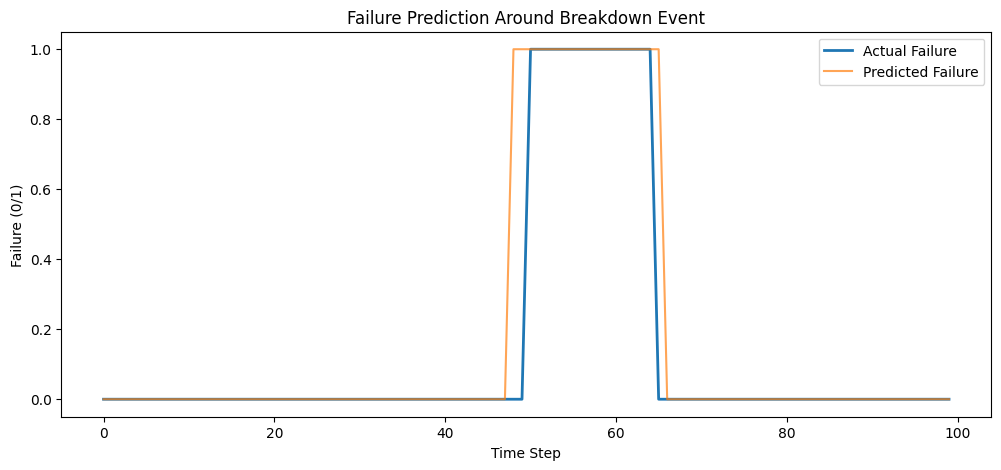

In [145]:
# Time-Series Prediction Visualization
import numpy as np
failure_indices = np.where(y_seq_test == 1)[0]

if len(failure_indices) > 0:
    idx = failure_indices[0]

    start = max(0, idx - 50)
    end = idx + 50

    plt.figure(figsize=(12,5))
    plt.plot(y_seq_test[start:end], label="Actual Failure", linewidth=2)
    plt.plot(y_pred_lstm[start:end], label="Predicted Failure", alpha=0.7)

    plt.title("Failure Prediction Around Breakdown Event")
    plt.xlabel("Time Step")
    plt.ylabel("Failure (0/1)")
    plt.legend()
    plt.show()
else:
    print("No failure event found in this test segment.")

In [146]:
# Save Models
joblib.dump(rf, "random_forest_model.pkl")
model.save("lstm_model.h5")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']